In [3]:
from pathlib import Path
import re
import json
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import zipfile
import os
import soundfile as sf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
base_dir_48k = Path("vctk_extracted/VCTK-Corpus/VCTK-Corpus/wav48")
base_dir_22k = Path("./vctk_22k")
base_dir_22k.mkdir(parents=True, exist_ok=True)
target_sr = 22050

for wav_path in base_dir_48k.rglob("*.wav"):
    audio, sr = librosa.load(wav_path, sr=None)
    audio_22k = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    out_path = base_dir_22k / wav_path.relative_to(base_dir_48k)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    sf.write(out_path, audio_22k, target_sr)

print("Downsampling done.")

KeyboardInterrupt: 

In [23]:
from pathlib import Path
import pandas as pd
import json
import random
import shutil

# Paths
wav_dir = Path("vctk_22k")  # 22k resampled WAVs
txt_dir = Path("vctk_extracted/VCTK-Corpus/VCTK-Corpus/txt")  # transcripts
subset_dir = Path("vctk_subset_15k")
subset_dir.mkdir(parents=True, exist_ok=True)

# Collect WAVs with transcripts
valid_samples = []
for speaker in sorted(wav_dir.iterdir()):
    spk_txt_dir = txt_dir / speaker.name
    if not speaker.is_dir() or not spk_txt_dir.exists():
        continue
    for wav_file in speaker.glob("*.wav"):
        txt_file = spk_txt_dir / wav_file.name.replace(".wav", ".txt")
        if txt_file.exists():
            valid_samples.append((wav_file, txt_file, speaker.name))

print(f"Total WAVs with transcripts: {len(valid_samples)}")

target_total = 15000
speakers = sorted(list(set([s for _, _, s in valid_samples])))
num_speakers = len(speakers)

# Base per speaker
base_per_speaker = target_total // num_speakers
extra = target_total % num_speakers

selected_samples = []
speaker_to_samples = {spk: [] for spk in speakers}
for wav_file, txt_file, spk in valid_samples:
    speaker_to_samples[spk].append((wav_file, txt_file))

for i, spk in enumerate(speakers):
    random.shuffle(speaker_to_samples[spk])
    take_n = base_per_speaker + (1 if i < extra else 0)
    take_n = min(take_n, len(speaker_to_samples[spk]))
    selected_samples.extend([(wav, txt, spk) for wav, txt in speaker_to_samples[spk][:take_n]])

print(f"Selected samples: {len(selected_samples)}")


Total WAVs with transcripts: 44070
Selected samples: 15000


In [24]:
metadata_list = []
for wav_file, txt_file, spk in selected_samples:
    out_spk_dir = subset_dir / spk
    out_spk_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy(wav_file, out_spk_dir / wav_file.name)
    with open(txt_file, "r") as f:
        text = f.read().strip()
    metadata_list.append({"speaker": spk, "wav": str(out_spk_dir / wav_file.name), "text": text})

metadata = pd.DataFrame(metadata_list)
speakers_sorted = sorted(metadata["speaker"].unique())
spk2idx = {s: i for i, s in enumerate(speakers_sorted)}
metadata["speaker_idx"] = metadata["speaker"].map(spk2idx)

# Save files
metadata.to_csv(subset_dir / "metadata.csv", index=False)
with open(subset_dir / "speaker2idx.json", "w") as f:
    json.dump(spk2idx, f, indent=2)
speaker_ids = metadata["speaker_idx"].values
np.save(subset_dir / "speaker_ids.npy", speaker_ids)

# ---- Add these lines for display ----
print("Metadata samples:", len(metadata))
print("Speaker IDs shape:", speaker_ids.shape)
print("Speakers:", len(spk2idx))
print(metadata.head())


Metadata samples: 15000
Speaker IDs shape: (15000,)
Speakers: 108
  speaker                                wav  \
0    p225  vctk_subset_15k/p225/p225_282.wav   
1    p225  vctk_subset_15k/p225/p225_200.wav   
2    p225  vctk_subset_15k/p225/p225_033.wav   
3    p225  vctk_subset_15k/p225/p225_219.wav   
4    p225  vctk_subset_15k/p225/p225_169.wav   

                                                text  speaker_idx  
0       It was at the Royal Concert Hall in Glasgow.            0  
1                            It looked like a river.            0  
2  It's really no great surprise, because the pri...            0  
3        They did not attack the themes of the book.            0  
4  Irvine said his company was intent on supporti...            0  


In [26]:
metadata = pd.read_csv("vctk_subset_15k/metadata.csv")
speaker_ids = metadata["speaker_idx"].values
np.save("./savedpaths/speaker_ids.npy", speaker_ids)
print("Saved speaker_ids.npy with shape:", speaker_ids.shape)

Saved speaker_ids.npy with shape: (15000,)


In [27]:
#audio parameters 
sr = 22050
n_fft = 1024
win_length = int(0.050 * sr)
hop_length = int(0.0125 * sr)
n_mels = 80
fmin = 125
fmax = 7600
power = 1.0

def preprocess_audio(path):
    y, _ = librosa.load(path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=25)
    rms = np.sqrt(np.mean(y**2)) if y.size > 0 else 0.0
    if rms > 0:
        y = y / (rms + 1e-9)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        win_length=win_length, n_mels=n_mels,
        fmin=fmin, fmax=fmax, power=power
    )
    mel = np.maximum(mel, 1e-6)
    return np.log(mel).T.astype(np.float32)  # (T, n_mels)

In [28]:
#  ge2e batch sampler 
class GE2EBatchSampler:
    def __init__(self, df, spk2idx, n_speakers=8, m_utterances=4):
        """
        df: metadata dataframe with 'speaker' column
        spk2idx: dict mapping speaker string -> integer index
        """
        self.df = df
        self.spk2idx = spk2idx
        self.n_speakers = n_speakers
        self.m_utterances = m_utterances
        self.speakers = df["speaker"].unique().tolist()

    def get_batch(self):
        """
        Returns:
            batch_paths: list of wav paths [N*M]
            batch_speaker_ids: list of integers [N*M]
            selected_speakers: list of speaker strings [N]
        """
        selected_speakers = random.sample(self.speakers, self.n_speakers)
        batch_paths, batch_speaker_ids = [], []
        for spk in selected_speakers:
            spk_wavs = self.df[self.df["speaker"] == spk]["wav"].tolist()
            selected_utts = random.choices(spk_wavs, k=self.m_utterances)
            batch_paths.extend(selected_utts)
            batch_speaker_ids.extend([self.spk2idx[spk]] * self.m_utterances)
        return batch_paths, batch_speaker_ids, selected_speakers

In [29]:
# Speaker Encoder 
class SpeakerEncoder(nn.Module):
    def __init__(self, n_mels=80, hidden_size=256, n_layers=3, embedding_size=256):
        super().__init__()
        self.lstm = nn.LSTM(n_mels, hidden_size, n_layers, batch_first=True, bidirectional=True)
        self.proj = nn.Linear(hidden_size * 2, embedding_size)

    def forward(self, x):
        # x: (B, T, n_mels)
        out, _ = self.lstm(x)          # (B, T, hidden_size*2)
        out = out.mean(dim=1)          # temporal average -> (B, hidden_size*2)
        out = self.proj(out)           # (B, embedding_size)
        out = F.normalize(out, p=2, dim=1)  # L2 normalize
        return out


In [30]:
# GE2E loss (softmax style with leave-one-out centroid)
class GE2ELoss(nn.Module):
    def __init__(self, init_w=10.0, init_b=-5.0):
        super().__init__()
        self.w_raw = nn.Parameter(torch.tensor(init_w))
        self.b = nn.Parameter(torch.tensor(init_b))

    def forward(self, embeddings, n_speakers, m_utterances):
        # embeddings: (N*M, D)
        device = embeddings.device
        D = embeddings.shape[1]

        emb = embeddings.view(n_speakers, m_utterances, D)  # (N, M, D)
        centroids = emb.mean(dim=1)  # (N, D)
        sum_per_speaker = centroids * m_utterances
        c_excl = (sum_per_speaker.unsqueeze(1) - emb) / (m_utterances - 1)  # (N, M, D)

        sims = []
        for j in range(n_speakers):
            for i in range(m_utterances):
                e_ji = emb[j, i]
                c_all = centroids.clone()
                c_all[j] = c_excl[j, i]
                cosines = F.cosine_similarity(e_ji.unsqueeze(0), c_all, dim=1)  # (N,)
                sims.append(cosines)
        sim_matrix = torch.stack(sims, dim=0).to(device)  # (N*M, N)

        w_pos = F.softplus(self.w_raw)
        sim_matrix = w_pos * sim_matrix + self.b

        targets = torch.arange(n_speakers, device=device).repeat_interleave(m_utterances)
        loss = F.cross_entropy(sim_matrix, targets)
        return loss

In [31]:
# Small helper to collate and pad features for a batch
def collate_and_pad(mel_list):
    """
    mel_list: list of (T_i, n_mels)
    returns: (B, T_max, n_mels)
    """
    max_len = max(m.shape[0] for m in mel_list)
    padded = []
    for m in mel_list:
        if m.shape[0] < max_len:
            pad_width = max_len - m.shape[0]
            m_p = np.pad(m, ((0, pad_width), (0, 0)), mode="constant")
        else:
            m_p = m
        padded.append(m_p)
    X = np.stack(padded).astype(np.float32)
    return X

In [33]:
n_speakers_batch = 8
m_utterances_batch = 4

sampler = GE2EBatchSampler(metadata, spk2idx, n_speakers=n_speakers_batch, m_utterances=m_utterances_batch)

hidden_size = 256
n_layers = 3
embedding_size = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SpeakerEncoder(n_mels=n_mels, hidden_size=hidden_size, n_layers=n_layers, embedding_size=embedding_size).to(device)
ge2e_loss = GE2ELoss().to(device)

main_params = [p for n, p in encoder.named_parameters()]
loss_params = [ge2e_loss.w_raw, ge2e_loss.b]
optimizer = optim.Adam([{"params": main_params, "lr":1e-4},
                        {"params": loss_params, "lr":1e-6}], betas=(0.9, 0.98))
grad_clip = 3.0

In [38]:
import nltk
import re
nltk.download('averaged_perceptron_tagger_eng')
!pip install g2p-en
from g2p_en import G2p
metadata["normalized"] = metadata["text"].str.lower()

def cleantext(text):
    text = str(text)
    text = re.sub(r"[^a-zA-Z0-9\s\']", "", text)
    return text

metadata["cleaned"] = metadata["normalized"].apply(cleantext)

nltk.download('averaged_perceptron_tagger_eng')
g2p = G2p()

def g2p_phonemes(text):
    phonemes = g2p(text)
    phonemes = [ph for ph in phonemes if ph.isalpha() or ph[:-1].isalpha()]
    return phonemes

metadata["phonemes"] = metadata["cleaned"].apply(g2p_phonemes)

specialtokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]
allphonemes = set()
for text in metadata["phonemes"]:
    allphonemes.update(text)

print("Number of unique phonemes before adding special tokens:", len(allphonemes))
print("All phonemes:", sorted(allphonemes))

phonemelist = specialtokens + sorted(list(allphonemes))
phonemetoid = {p: i for i, p in enumerate(phonemelist)}
idtophoneme = {i: p for p, i in phonemetoid.items()}

sos_id = phonemetoid["<SOS>"]
eos_id = phonemetoid["<EOS>"]
unk_id = phonemetoid["<UNK>"]
pad_id = phonemetoid["<PAD>"]

def tokenizetext(seq):
    return [sos_id] + [phonemetoid.get(ph, unk_id) for ph in seq] + [eos_id]

metadata["phoneme_ids"] = metadata["phonemes"].apply(tokenizetext)
maxlength = max(len(seq) for seq in metadata["phoneme_ids"])

def padsequence(token, maxlength, pad_id):
    return token + [pad_id] * (maxlength - len(token))

metadata["phoneme_id_padded"] = metadata["phoneme_ids"].apply(
    lambda x: padsequence(x, maxlength, pad_id)
)

phoneme_ids_array = np.array(metadata["phoneme_id_padded"].tolist())
save_path = "./savedpaths/phoneme_id_padded.npy"
np.save(save_path, phoneme_ids_array)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jupyter-prasanna_kasar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jupyter-prasanna_kasar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Number of unique phonemes before adding special tokens: 69
All phonemes: ['AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0', 'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH', 'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH0', 'UH1', 'UH2', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH']


In [41]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

# --- CONFIGURATION ---
# TODO: Update this path to point to your metadata file (e.g., a CSV)
# The file should contain columns named "wav" (for the audio file path) and "speaker".
METADATA_PATH = "vctk_subset_15k/metadata.csv"

# Audio processing parameters (consistent with Tacotron2 and speaker embeddings)
sr = 22050
n_fft = 1024
hop_length = 256
win_length = 1024
n_mels = 80
fmin = 125
fmax = 7600
power = 1.0
# --------------------

# --- DATA LOADING ---
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(
        f"Metadata file not found at '{METADATA_PATH}'. "
        "Please update the METADATA_PATH variable in this script."
    )
print(f"Loading metadata from {METADATA_PATH}...")
metadata = pd.read_csv(METADATA_PATH)
print(f"Found {len(metadata)} audio files to process.")
# --------------------


mel_list = []
speaker_list = []
lengths = []

# --- PROCESSING LOOP with TQDM ---
# Iterate through the metadata with a progress bar
for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Preprocessing audio"):
    try:
        wav_path = row["wav"]
        y, _ = librosa.load(wav_path, sr=sr, mono=True)

        # Trim leading and trailing silence
        y, _ = librosa.effects.trim(y, top_db=25)

        # Normalize volume
        rms = np.sqrt(np.mean(y**2)) if y.size > 0 else 0.0
        if rms > 0:
            y = y / (rms + 1e-9)

        # Compute Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, n_mels=n_mels,
            fmin=fmin, fmax=fmax, power=power
        )

        # Convert to log scale
        mel_spec = np.maximum(mel_spec, 1e-6)
        mel = np.log(mel_spec).T.astype(np.float32)  # shape (T, n_mels)

        mel_list.append(mel)
        speaker_list.append(row["speaker"])
        lengths.append(mel.shape[0])

    except Exception as e:
        print(f"\nWarning: Could not process file {wav_path}. Error: {e}")
# --------------------------------

if lengths:
    max_len = max(lengths)
    print(f"\nPreprocessing complete.")
    print(f"Max mel length: {max_len}")

else:
    print("\nNo audio files were processed.")


Loading metadata from vctk_subset_15k/metadata.csv...
Found 15000 audio files to process.


Preprocessing audio: 100%|██████████| 15000/15000 [01:01<00:00, 243.74it/s]


Preprocessing complete.
Max mel length: 1303


In [42]:
#Pad all to same length
def pad_mel(mel, max_len):
    pad_width = max_len - mel.shape[0]
    if pad_width > 0:
        return np.pad(mel, ((0, pad_width), (0, 0)), mode="constant")
    else:
        return mel[:max_len]

mels_padded = np.array([pad_mel(m, max_len) for m in mel_list], dtype=np.float32)
print("Final padded mels shape:", mels_padded.shape)  

np.save("./savedpaths/mels_padded.npy", mels_padded)
# np.save("./savedpaths/speakers.npy", np.array(speaker_list))
speakers = sorted(metadata["speaker"].unique())
speaker_to_id = {s: i for i, s in enumerate(speakers)}
metadata["speaker_idx"] = metadata["speaker"].map(speaker_to_id)

speaker_ids_array = np.array(metadata["speaker_idx"], dtype=np.int32)
np.save("./savedpaths/speakers.npy", speaker_ids_array)
print("Loaded shape:", mels_padded.shape)  
print("One mel shape:", mels_padded[0].shape)
print(mels_padded[0][:5, :5]) 

Final padded mels shape: (15000, 1303, 80)
Loaded shape: (15000, 1303, 80)
One mel shape: (1303, 80)
[[-2.7932866  -2.9347453  -3.2531276  -3.3159378  -3.4031188 ]
 [-3.7574978  -3.331563   -4.1948376  -3.5745256  -3.9610925 ]
 [-1.0535375  -0.67723167 -0.5243856  -0.12150837  0.25299537]
 [ 0.47732818  1.0868286   0.5424421   0.98337495  1.3256509 ]
 [ 0.87694114  1.8786237   1.3721995   1.536559    1.2138407 ]]


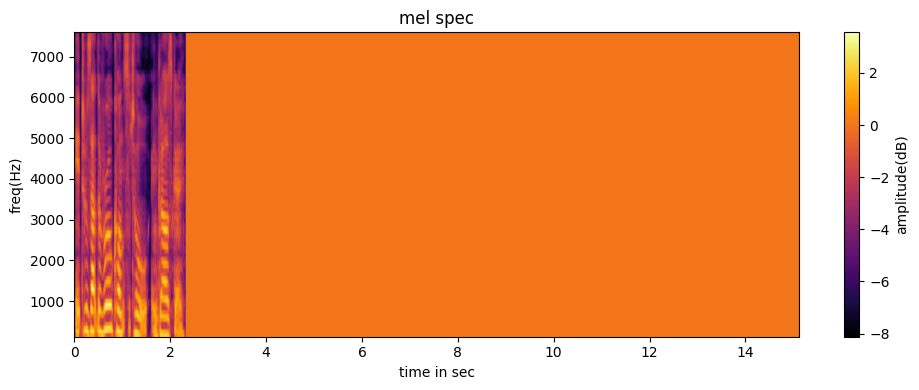

In [43]:
mel = mels_padded[0]
mel_T = mel.T

n_frames = mel_T.shape[1]
time = np.arange(n_frames) * hop_length / sr
mel_freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)
plt.figure(figsize=(10, 4))
plt.imshow(mel_T, aspect="auto", origin="lower",
           extent=[time[0], time[-1], mel_freqs[0], mel_freqs[-1]],
           cmap="inferno")
plt.colorbar(label="amplitude(dB)")
plt.title("mel spec")
plt.xlabel("time in sec")
plt.ylabel("freq(Hz)")
plt.tight_layout()
plt.show()

In [44]:
import numpy as np

mel = mels_padded[0]  # shape: [n_mels, T]

# Calculate stats using NumPy
mel_mean = np.mean(mel)
mel_var = np.var(mel)  # or np.var(mel, ddof=1) for unbiased sample variance

print(f"Mel Spectrogram — Mean (dB): {mel_mean:.4f}, Variance (dB^2): {mel_var:.4f}")


Mel Spectrogram — Mean (dB): -0.4018, Variance (dB^2): 1.4841


In [45]:
n_fft = 1024
hop_length = 256
win_length = 1024

def mel_to_audio(mel, n_iter=60):
    mel = librosa.db_to_power(mel.T)  
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)
    inv_mel = np.linalg.pinv(mel_basis)@mel
    audio = librosa.griffinlim(inv_mel, n_iter=n_iter, hop_length=hop_length, win_length=win_length)
    
    return audio

audio = mel_to_audio(mels_padded[1])
sf.write("audio_griffinlim.wav", audio, sr)

import IPython.display as ipd
ipd.Audio(audio, rate=sr)

In [46]:
texts = np.load("savedpaths/phoneme_id_padded.npy")
mels = np.load("savedpaths/mels_padded.npy")
speaker_ids = np.load("savedpaths/speakers.npy")

In [47]:
from torch.utils.data import Dataset, DataLoader
ref_mels = mels_padded.copy()
class MultiSpeakerTTSDataset(Dataset):
    def __init__(self, texts, mels, ref_mels, pad_id=0):
        """
        texts: numpy array of tokenized text sequences
        mels: numpy array of target mel spectrograms
        ref_mels: numpy array of reference mel spectrograms for speaker embedding
        """
        self.texts = torch.from_numpy(texts).long()
        self.mels = torch.from_numpy(mels).float()
        self.ref_mels = torch.from_numpy(ref_mels).float()  # new
        self.pad_id = pad_id

        assert len(self.texts) == len(self.mels) == len(self.ref_mels), "All lengths must match"

        self.text_lengths = (self.texts != pad_id).sum(dim=1)
        self.mel_lengths = (self.mels.abs().sum(dim=2) != 0).sum(dim=1)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        mel = self.mels[index]
        ref_mel = self.ref_mels[index]  # new
        text_len = self.text_lengths[index]
        mel_len = self.mel_lengths[index]

        #stop token target: 0 for valid frames, 1 from last frame onward
        stop_target = torch.zeros(mel.size(0))
        stop_target[mel_len-1:] = 1.0

        return {
            "text": text,
            "mel": mel,
            "ref_mel": ref_mel,  # new
            "text_len": text_len,
            "mel_len": mel_len,
            "stop_target": stop_target
        }

batch_size = 32
dataset = MultiSpeakerTTSDataset(texts, mels, ref_mels, pad_id=0)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
sample = dataset[0]
print("One sample keys:", sample.keys())

for batch in loader:
    print("Text:", batch["text"].shape) # [B, T_text]
    print("Mel target:", batch["mel"].shape)# [B, T_mel, n_mels]
    print("Ref mel:", batch["ref_mel"].shape)   #[B, T_ref, n_mels] for speaker embedding
    print("Text len:", batch["text_len"].shape)
    print("Mel len:", batch["mel_len"].shape)
    print("Stop target:", batch["stop_target"].shape)
    break

15000
One sample keys: dict_keys(['text', 'mel', 'ref_mel', 'text_len', 'mel_len', 'stop_target'])
Text: torch.Size([32, 119])
Mel target: torch.Size([32, 1303, 80])
Ref mel: torch.Size([32, 1303, 80])
Text len: torch.Size([32])
Mel len: torch.Size([32])
Stop target: torch.Size([32, 1303])


In [48]:
#TACOTRON2 MODEL IMPLEMENTATION

#masking
def get_mask_from_lengths(lengths, max_len=None):
    """
    lengths: LongTensor [B]
    returns: BoolTensor mask [B, max_len] where True indicates padding positions
    """
    B = lengths.size(0)
    if max_len is None:
        max_len = lengths.max().item()
    ids = torch.arange(0, max_len, device=lengths.device).unsqueeze(0).expand(B, -1)
    mask = ids >= lengths.unsqueeze(1)
    return mask

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LinearNorm(nn.Module):
    def __init__(self, in_dim, out_dim, bias=False, w_init_gain='linear'):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight, gain=nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear(x)

# Prenet
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes=(256, 256)):
        super().__init__()
        in_sizes = [in_dim] + list(sizes[:-1])
        self.layers = nn.ModuleList(
            [LinearNorm(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)]
        )

    def forward(self, x):
        for linear in self.layers:
            x = F.relu(linear(x))
            x = F.dropout(x, p=0.5, training=self.training)
        return x

In [50]:
#Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, enc_conv_channels=512,
                 enc_conv_kernel=5, enc_conv_layers=3, enc_lstm_dim=256,
                 embed_padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=embed_padding_idx)

        convs = []
        in_ch = embed_dim
        for _ in range(enc_conv_layers):
            convs.append(nn.Sequential(
                nn.Conv1d(in_ch, enc_conv_channels, kernel_size=enc_conv_kernel,
                          padding=enc_conv_kernel // 2),
                nn.BatchNorm1d(enc_conv_channels),
                nn.ReLU(),
                nn.Dropout(0.5),
            ))
            in_ch = enc_conv_channels
        self.convolutions = nn.ModuleList(convs)
        self.lstm = nn.LSTM(enc_conv_channels, enc_lstm_dim, num_layers=1, batch_first=True, bidirectional=True)

    def forward(self, text_ids, text_lengths):
        """
        text_ids: [B, T_text]
        text_lengths: [B]
        returns:
          memory: encoder outputs [B, T_text, 2*enc_lstm_dim]
        """
        x = self.embedding(text_ids)           # [B, T, embed_dim]
        x = x.transpose(1, 2)                  # [B, embed_dim, T]
        for conv in self.convolutions:
            x = conv(x)
        x = x.transpose(1, 2)                  # [B, T, enc_conv_channels]

        lengths_cpu = text_lengths.cpu()
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        # outputs: [B, T_text, 2*enc_lstm_dim]
        return outputs

In [51]:
#Location sensitive attention
class LocationLayer(nn.Module):
    def __init__(self, attention_n_filters=32, attention_kernel_size=31, attention_dim=128):
        super().__init__()
        self.location_conv = nn.Conv1d(2, attention_n_filters,
                                       kernel_size=attention_kernel_size,
                                       padding=(attention_kernel_size - 1) // 2,
                                       bias=False)
        self.location_dense = nn.Linear(attention_n_filters, attention_dim, bias=False)

    def forward(self, attn_weights_cat):
        """
        attn_weights_cat: [B, 2, T_text]
        returns: [B, T_text, attention_dim]
        """
        processed = self.location_conv(attn_weights_cat)      # [B, filters, T]
        processed = processed.transpose(1, 2)                 # [B, T, filters]
        processed = self.location_dense(processed)            # [B, T, attention_dim]
        return processed

class LocationSensitiveAttention(nn.Module):
    def __init__(self, attention_rnn_dim, encoder_out_dim, attention_dim=128,
                 attention_n_filters=32, attention_kernel_size=31):
        super().__init__()
        self.query_layer = nn.Linear(attention_rnn_dim, attention_dim, bias=False)
        self.memory_layer = nn.Linear(encoder_out_dim, attention_dim, bias=False)
        self.location_layer = LocationLayer(attention_n_filters, attention_kernel_size, attention_dim)
        self.v = nn.Linear(attention_dim, 1, bias=True)
        self.score_mask_value = -float("inf")

    def get_alignment_energies(self, query, processed_memory, attn_weights_cat):
        """
        query: [B, attention_rnn_dim]
        processed_memory: [B, T_text, A]
        attn_weights_cat: [B, 2, T_text]
        returns energies: [B, T_text]
        """
        processed_query = self.query_layer(query).unsqueeze(1)    # [B, 1, A]
        processed_location = self.location_layer(attn_weights_cat) # [B, T, A]
        energies = self.v(torch.tanh(processed_query + processed_location + processed_memory))
        energies = energies.squeeze(-1)                           # [B, T_text]
        return energies

    def forward(self, query, memory, processed_memory, attn_weights, attn_weights_cum, memory_lengths):
        """
        query: [B, attention_rnn_dim]
        memory: [B, T_text, encoder_out_dim]
        processed_memory: [B, T_text, A]
        attn_weights: [B, T_text]
        attn_weights_cum: [B, T_text]
        memory_lengths: [B]
        returns:
          context: [B, encoder_out_dim]
          attn_weights: [B, T_text]
        """
        attn_weights_cat = torch.stack([attn_weights, attn_weights_cum], dim=1)  # [B,2,T_text]
        energies = self.get_alignment_energies(query, processed_memory, attn_weights_cat)

        if memory_lengths is not None:
            mask = get_mask_from_lengths(memory_lengths, max_len=memory.size(1))  # [B, T_text]
            energies = energies.masked_fill(mask, self.score_mask_value)

        attn_weights = F.softmax(energies, dim=1)      # [B, T_text]
        attn_weights_cum = attn_weights_cum + attn_weights

        context = torch.bmm(attn_weights.unsqueeze(1), memory).squeeze(1)  # [B, encoder_out_dim]
        return context, attn_weights, attn_weights_cum

In [52]:
#decoder
class Decoder(nn.Module):
    def __init__(self,
                 n_mel_channels=80,
                 frames_per_step=1,
                 prenet_dims=(256, 256),
                 attention_rnn_dim=1024,
                 decoder_rnn_dim=1024,
                 encoder_out_dim=512,  # must match encoder output dim (2*enc_lstm_dim + speaker_dim)
                 attention_dim=128,
                 attention_n_filters=32,
                 attention_kernel_size=31,
                 p_decoder_dropout=0.1):
        super().__init__()
        self.n_mel_channels = n_mel_channels
        self.frames_per_step = frames_per_step

        self.prenet = Prenet(n_mel_channels * frames_per_step, prenet_dims)

        # RNNs (LSTMCells)
        self.attention_rnn = nn.LSTMCell(prenet_dims[-1] + encoder_out_dim, attention_rnn_dim)
        self.decoder_rnn = nn.LSTMCell(attention_rnn_dim + encoder_out_dim, decoder_rnn_dim)

        # attention
        self.attention_layer = LocationSensitiveAttention(
            attention_rnn_dim=attention_rnn_dim,
            encoder_out_dim=encoder_out_dim,
            attention_dim=attention_dim,
            attention_n_filters=attention_n_filters,
            attention_kernel_size=attention_kernel_size
        )

        self.linear_projection = nn.Linear(decoder_rnn_dim + encoder_out_dim, n_mel_channels * frames_per_step)
        self.gate_projection = nn.Linear(decoder_rnn_dim + encoder_out_dim, 1)
        self.dropout = p_decoder_dropout

    def initialize_decoder_states(self, memory):
        B = memory.size(0)
        device = memory.device

        # RNN states
        self.attention_hidden = torch.zeros(B, self.attention_rnn.hidden_size, device=device)
        self.attention_cell = torch.zeros(B, self.attention_rnn.hidden_size, device=device)
        self.decoder_hidden = torch.zeros(B, self.decoder_rnn.hidden_size, device=device)
        self.decoder_cell = torch.zeros(B, self.decoder_rnn.hidden_size, device=device)

        # attention weights
        T_text = memory.size(1)
        self.attention_weights = torch.zeros(B, T_text, device=device)
        self.attention_weights_cum = torch.zeros(B, T_text, device=device)
        self.attention_context = torch.zeros(B, memory.size(2), device=device)

    def parse_decoder_inputs(self, mel_targets):
        """
        mel_targets: [B, T_out, n_mel]
        returns: inputs to decoder time steps as [B, T_out, n_mel*frames_per_step]
        """
        # here frames_per_step == 1 in most setups, so just return mel_targets
        return mel_targets

    def decode(self, prenet_out, processed_memory, memory, memory_lengths):
        cell_input = torch.cat([prenet_out, self.attention_context], dim=1)  # [B, prenet_dim + ctx]
        self.attention_hidden, self.attention_cell = self.attention_rnn(cell_input, (self.attention_hidden, self.attention_cell))
        self.attention_hidden = F.dropout(self.attention_hidden, p=self.dropout, training=self.training)

        context, self.attention_weights, self.attention_weights_cum = self.attention_layer(
            self.attention_hidden, memory, processed_memory, self.attention_weights, self.attention_weights_cum, memory_lengths
        )
        self.attention_context = context

        decoder_input = torch.cat([self.attention_hidden, context], dim=1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(decoder_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(self.decoder_hidden, p=self.dropout, training=self.training)

        proj_input = torch.cat([self.decoder_hidden, context], dim=1)
        mel_out = self.linear_projection(proj_input)  # [B, n_mel*fps]
        gate_out = self.gate_projection(proj_input)   # [B, 1]
        return mel_out, gate_out, self.attention_weights

    def forward(self, memory, memory_lengths, mel_targets=None, teacher_forcing=True,
                gate_threshold=0.5, max_decoder_steps=1000):
        """
        memory: [B, T_text, E]
        memory_lengths: [B]
        mel_targets: [B, T_out, n_mel]
        returns:
          mel_outputs: [B, T_out, n_mel]
          gate_outputs: [B, T_out]
          alignments:   [B, T_out, T_text]
        """
        self.initialize_decoder_states(memory)
        B = memory.size(0)
        device = memory.device

        # processed memory for attention
        processed_memory = self.attention_layer.memory_layer(memory)  # [B, T_text, A]
        go_frame = torch.zeros(B, self.n_mel_channels * self.frames_per_step, device=device)

        mel_outputs, gate_outputs, alignments = [], [], []

        if teacher_forcing:
            assert mel_targets is not None, "mel_targets must be provided during teacher forcing."
            decoder_inputs = self.parse_decoder_inputs(mel_targets)   # [B, T_out, n_mel]
            T_out = decoder_inputs.size(1)

            prev_output = go_frame
            for t in range(T_out):
                # prenet can accept (..., in_dim), so provide (B, in_dim)
                prenet_in = prev_output
                prenet_out = self.prenet(prenet_in)  # [B, prenet_dim]
                mel_out, gate_out, attn = self.decode(prenet_out, processed_memory, memory, memory_lengths)
                mel_outputs.append(mel_out.unsqueeze(1))
                gate_outputs.append(gate_out.unsqueeze(1))
                alignments.append(attn.unsqueeze(1))

                # teacher forcing: next input is ground truth frame
                prev_output = decoder_inputs[:, t, :]

        else:
            prev_output = go_frame
            for step in range(max_decoder_steps):
                prenet_in = prev_output
                prenet_out = self.prenet(prenet_in)
                mel_out, gate_out, attn = self.decode(prenet_out, processed_memory, memory, memory_lengths)
                mel_outputs.append(mel_out.unsqueeze(1))
                gate_outputs.append(gate_out.unsqueeze(1))
                alignments.append(attn.unsqueeze(1))

                # next input is the predicted frame (autoregressive)
                prev_output = mel_out

                # gating: check whether all elements in batch predict stop
                gate_probs = torch.sigmoid(gate_out).squeeze(-1)  # [B]
                # if all elements in the batch have gate > threshold -> stop
                if torch.all(gate_probs > gate_threshold):
                    break

        mel_outputs = torch.cat(mel_outputs, dim=1)    # [B, T_out, n_mel*fps]
        gate_outputs = torch.cat(gate_outputs, dim=1).squeeze(-1)  # [B, T_out]
        alignments = torch.cat(alignments, dim=1)     # [B, T_out, T_text]
        return mel_outputs, gate_outputs, alignments

In [53]:
#postnet
class Postnet(nn.Module):
    def __init__(self, n_mel_channels=80, postnet_embedding_dim=512, postnet_kernel_size=5, postnet_n_convolutions=5):
        super().__init__()
        layers = []
        layers.append(nn.Sequential(
            nn.Conv1d(n_mel_channels, postnet_embedding_dim, kernel_size=postnet_kernel_size,
                      padding=postnet_kernel_size // 2),
            nn.BatchNorm1d(postnet_embedding_dim),
            nn.Tanh(),
            nn.Dropout(0.5)
        ))
        for _ in range(1, postnet_n_convolutions - 1):
            layers.append(nn.Sequential(
                nn.Conv1d(postnet_embedding_dim, postnet_embedding_dim, kernel_size=postnet_kernel_size,
                          padding=postnet_kernel_size // 2),
                nn.BatchNorm1d(postnet_embedding_dim),
                nn.Tanh(),
                nn.Dropout(0.5)
            ))
        layers.append(nn.Sequential(
            nn.Conv1d(postnet_embedding_dim, n_mel_channels, kernel_size=postnet_kernel_size,
                      padding=postnet_kernel_size // 2),
            nn.BatchNorm1d(n_mel_channels),
            nn.Dropout(0.5)
        ))
        self.convolutions = nn.ModuleList(layers)

    def forward(self, mel_outputs):
        """
        mel_outputs: [B, T_out, n_mel]
        returns residual: [B, T_out, n_mel]
        """
        x = mel_outputs.transpose(1, 2)  # [B, n_mel, T]
        for layer in self.convolutions:
            x = layer(x)
        x = x.transpose(1, 2)  # [B, T, n_mel]
        return x

In [56]:
#complete tacotron2
class Tacotron2(nn.Module):
    def __init__(self,
                 vocab_size,
                 n_mel_channels=80,
                 embed_dim=512,
                 enc_conv_channels=512,
                 enc_conv_kernel=5,
                 enc_conv_layers=3,
                 enc_lstm_dim=256,
                 prenet_dims=(256, 256),
                 attention_rnn_dim=1024,
                 decoder_rnn_dim=1024,
                 attention_dim=128,
                 attention_n_filters=32,
                 attention_kernel_size=31,
                 postnet_embedding_dim=512,
                 postnet_kernel_size=5,
                 postnet_n_convolutions=5,
                 frames_per_step=1,
                 pad_id=0,
                 speaker_embedding_dim=256):
        super().__init__()

        self.n_mel_channels = n_mel_channels
        self.pad_id = pad_id
        self.speaker_embedding_dim = speaker_embedding_dim

        self.encoder = Encoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            enc_conv_channels=enc_conv_channels,
            enc_conv_kernel=enc_conv_kernel,
            enc_conv_layers=enc_conv_layers,
            enc_lstm_dim=enc_lstm_dim,
            embed_padding_idx=pad_id,
        )

        # encoder_out_dim should be 2*enc_lstm_dim + speaker_embedding_dim when speaker embedding is concatenated
        self.decoder = Decoder(
            n_mel_channels=n_mel_channels,
            frames_per_step=frames_per_step,
            prenet_dims=prenet_dims,
            attention_rnn_dim=attention_rnn_dim,
            decoder_rnn_dim=decoder_rnn_dim,
            encoder_out_dim=enc_lstm_dim * 2 + speaker_embedding_dim,
            attention_dim=attention_dim,
            attention_n_filters=attention_n_filters,
            attention_kernel_size=attention_kernel_size,
        )

        self.postnet = Postnet(
            n_mel_channels=n_mel_channels,
            postnet_embedding_dim=postnet_embedding_dim,
            postnet_kernel_size=postnet_kernel_size,
            postnet_n_convolutions=postnet_n_convolutions,
        )

    def forward(self, text_ids, text_lengths, mel_targets=None, teacher_forcing=True, speaker_embedding=None):

        memory = self.encoder(text_ids, text_lengths)  # [B, T_text, 2*enc_lstm_dim]

        if speaker_embedding is not None:
            # concat speaker embedding to every timestep of encoder memory
            speaker_exp = speaker_embedding.unsqueeze(1).expand(-1, memory.size(1), -1)
            memory = torch.cat([memory, speaker_exp], dim=-1)  # [B, T_text, 2*enc_lstm_dim + spk_dim]

        mel_out, gate_out, alignments = self.decoder(
            memory=memory,
            memory_lengths=text_lengths,
            mel_targets=mel_targets,
            teacher_forcing=teacher_forcing
        )
        residual = self.postnet(mel_out)  # [B, T_out, n_mel]
        mel_out_postnet = mel_out + residual
        return mel_out, mel_out_postnet, gate_out, alignments

In [59]:
# with torch.no_grad():
#     speaker_emb = speaker_encoder(ref_mel)
#     speaker_emb = speaker_emb / torch.norm(speaker_emb, dim=1, keepdim=True)

ref_mel = next(iter(loader))["ref_mel"].to(device)
with torch.no_grad():
    emb = speaker_encoder(ref_mel)
print(emb.shape, emb.mean().item(), emb.std().item())


NameError: name 'speaker_encoder' is not defined

In [ ]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

max_id = texts.max()  
vocab_size = int(max_id) + 1
print("Vocab size (number of phonemes):", vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize fresh model
model = Tacotron2(vocab_size=vocab_size).to(device)

# Initialize fresh optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start fresh loss histories
mel_loss_hist = []
# stop_loss_hist = []

num_epochs = 4
# stop_loss_weight = 5.0

# Load speaker encoder (can be pre-trained)
speaker_encoder = SpeakerEncoder().to(device)
speaker_encoder.eval()
for param in speaker_encoder.parameters():
    param.requires_grad = False

mse_loss = nn.MSELoss()
# bce_loss = nn.BCEWithLogitsLoss()

def plot_attention(attn, step_or_epoch, save_dir="./attention_plots"):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(attn, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar()
    plt.xlabel("Encoder Steps")
    plt.ylabel("Decoder Steps")
    plt.title(f"Attention Heatmap ({step_or_epoch})")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"attention_{step_or_epoch}.png"))
    plt.close()

for epoch in range(num_epochs):
    model.train()
    epoch_mel_loss = 0.0
    # epoch_stop_loss = 0.0

    for batch_idx, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
        text = batch["text"].to(device)
        mel = batch["mel"].to(device)
        text_len = batch["text_len"].to(device)
        # stop_target = batch["stop_target"].to(device)
        ref_mel = batch["ref_mel"].to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            speaker_emb = speaker_encoder(ref_mel)
        
        mel_pred, mel_postnet, gate_pred, alignments = model(
            text, text_len, mel_targets=mel, teacher_forcing=True, speaker_embedding=speaker_emb
        )

        mel_loss = mse_loss(mel_postnet, mel)
        # stop_loss = bce_loss(gate_pred.squeeze(1), stop_target)
        total_loss = mel_loss
        # total_loss = mel_loss + stop_loss_weight * stop_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_mel_loss += mel_loss.item()
        # epoch_stop_loss += stop_loss.item()

        if batch_idx % 500 == 0:
            attn = alignments[0].detach().cpu().numpy()
            plot_attention(attn, f"epoch{epoch+1}_step{batch_idx}")
    
    mel_loss_hist.append(epoch_mel_loss / len(loader))
    # stop_loss_hist.append(epoch_stop_loss / len(loader))
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Mel Loss: {epoch_mel_loss/len(loader):.4f} ")
        # f"Stop Loss: {epoch_stop_loss/len(loader):.4f}
    
    SAVE_PATH = f"./tacotron2_checkpoint_epoch{epoch+1:02d}.pth"
    checkpoint = {
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "mel_loss_hist": mel_loss_hist,
        # "stop_loss_hist": stop_loss_hist
    }
    torch.save(checkpoint, SAVE_PATH)
    print(f"Checkpoint saved at {SAVE_PATH}")

Vocab size (number of phonemes): 73


Epoch 1: 100%|██████████| 469/469 [18:07<00:00,  2.32s/it]


Epoch [1/4] | Mel Loss: 1.2409 
Checkpoint saved at ./tacotron2_checkpoint_epoch01.pth


Epoch 2: 100%|██████████| 469/469 [23:20<00:00,  2.99s/it]


Epoch [2/4] | Mel Loss: 0.9940 
Checkpoint saved at ./tacotron2_checkpoint_epoch02.pth


Epoch 3: 100%|██████████| 469/469 [28:54<00:00,  3.70s/it]


Epoch [3/4] | Mel Loss: 0.8905 
Checkpoint saved at ./tacotron2_checkpoint_epoch03.pth


Epoch 4:   6%|▌         | 27/469 [01:40<26:57,  3.66s/it]

In [62]:
# ===================================================================
# TRAINING SCRIPT PART
# ===================================================================

# --- 1. Initialize Optimizer and Scheduler ---
start_learning_rate = 1e-3
end_learning_rate = 1e-5
NUM_EPOCHS = 14 

optimizer = torch.optim.Adam(model.parameters(), lr=start_learning_rate)
gamma = (end_learning_rate / start_learning_rate) ** (1 / NUM_EPOCHS)
scheduler = ExponentialLR(optimizer, gamma=gamma)


# --- 2. Load from Checkpoint ---
PREVIOUS_CHECKPOINT_PATH = "tacotron2_checkpoint_epoch10.pth"
start_epoch = 0
mel_loss_hist = []
stop_loss_hist = []

if PREVIOUS_CHECKPOINT_PATH and os.path.exists(PREVIOUS_CHECKPOINT_PATH):
    print(f"Loading checkpoint: {PREVIOUS_CHECKPOINT_PATH}")
    checkpoint = torch.load(PREVIOUS_CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"]
    mel_loss_hist = checkpoint.get("mel_loss_hist", [])
    stop_loss_hist = checkpoint.get("stop_loss_hist", [])
    print(f"Resuming training from Epoch {start_epoch + 1}")
else:
    print(f"Checkpoint not found at '{PREVIOUS_CHECKPOINT_PATH}'. Cannot resume.")


# --- 3. Training Setup ---
stop_loss_weight = 5.0
speaker_encoder.eval()
for param in speaker_encoder.parameters():
    param.requires_grad = False

mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()

# --- 4. Training Loop ---
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    epoch_mel_loss = 0.0
    epoch_stop_loss = 0.0

    for batch_idx, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
        text = batch["text"].to(device)
        mel = batch["mel"].to(device)
        text_len = batch["text_len"].to(device)
        stop_target = batch["stop_target"].to(device)
        ref_mel = batch["ref_mel"].to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            speaker_emb = speaker_encoder(ref_mel)

        mel_pred, mel_postnet, gate_pred, alignments = model(
            text, text_len, mel_targets=mel, teacher_forcing=True, speaker_embedding=speaker_emb
        )

        mel_loss = mse_loss(mel_postnet, mel)
        stop_loss = bce_loss(gate_pred.squeeze(-1), stop_target)
        total_loss = mel_loss + stop_loss_weight * stop_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_mel_loss += mel_loss.item()
        epoch_stop_loss += stop_loss.item()

    # --- Logging, Stepping Scheduler, and Saving ---
    mel_loss_hist.append(epoch_mel_loss / len(loader))
    stop_loss_hist.append(epoch_stop_loss / len(loader))
    
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Mel Loss: {epoch_mel_loss/len(loader):.4f} | "
          f"Stop Loss: {epoch_stop_loss/len(loader):.4f} | "
          f"LR: {current_lr:.6f}")

    scheduler.step()

    SAVE_PATH = f"./tacotron2_checkpoint_epoch{epoch+1:02d}.pth"
    checkpoint = {
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "mel_loss_hist": mel_loss_hist,
        "stop_loss_hist": stop_loss_hist
    }
    torch.save(checkpoint, SAVE_PATH)
    print(f"Checkpoint saved at {SAVE_PATH}")

Loading checkpoint: tacotron2_checkpoint_epoch10.pth
Resuming training from Epoch 11


Epoch 11: 100%|██████████| 469/469 [18:21<00:00,  2.35s/it]


Epoch [11/14] | Mel Loss: 0.3672 | Stop Loss: 0.0035 | LR: 0.000100
Checkpoint saved at ./tacotron2_checkpoint_epoch11.pth


Epoch 12: 100%|██████████| 469/469 [18:22<00:00,  2.35s/it]


Epoch [12/14] | Mel Loss: 0.3285 | Stop Loss: 0.0033 | LR: 0.000072
Checkpoint saved at ./tacotron2_checkpoint_epoch12.pth


Epoch 13: 100%|██████████| 469/469 [18:28<00:00,  2.36s/it]


Epoch [13/14] | Mel Loss: 0.3020 | Stop Loss: 0.0032 | LR: 0.000052
Checkpoint saved at ./tacotron2_checkpoint_epoch13.pth


Epoch 14: 100%|██████████| 469/469 [18:29<00:00,  2.37s/it]


Epoch [14/14] | Mel Loss: 0.2837 | Stop Loss: 0.0031 | LR: 0.000037
Checkpoint saved at ./tacotron2_checkpoint_epoch14.pth


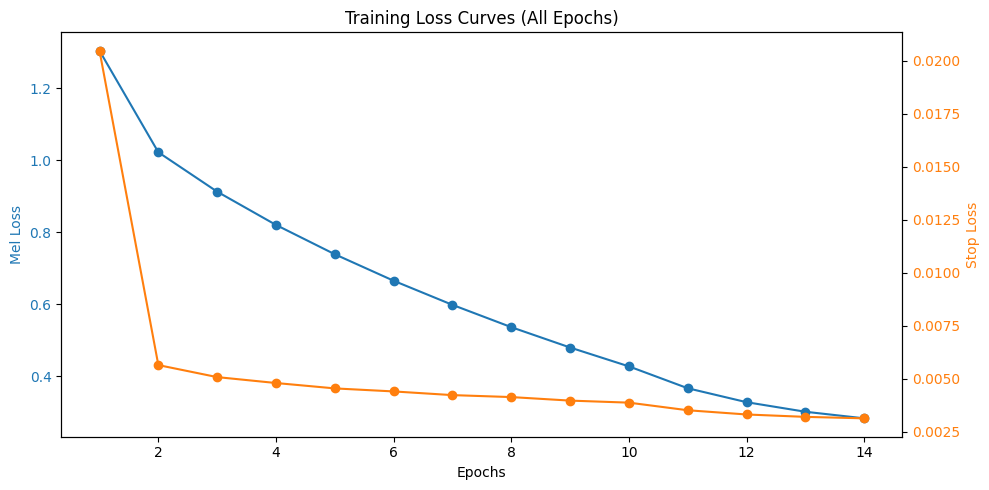

In [63]:
epochs = range(1, len(mel_loss_hist) + 1)  

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Mel Loss
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Mel Loss', color=color)
ax1.plot(epochs, mel_loss_hist, marker='o', color=color, label="Mel Loss")
ax1.tick_params(axis='y', labelcolor=color)

# Plot Stop Loss
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Stop Loss', color=color)
ax2.plot(epochs, stop_loss_hist, marker='o', color=color, label="Stop Loss")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss Curves (All Epochs)")
fig.tight_layout()
plt.show()


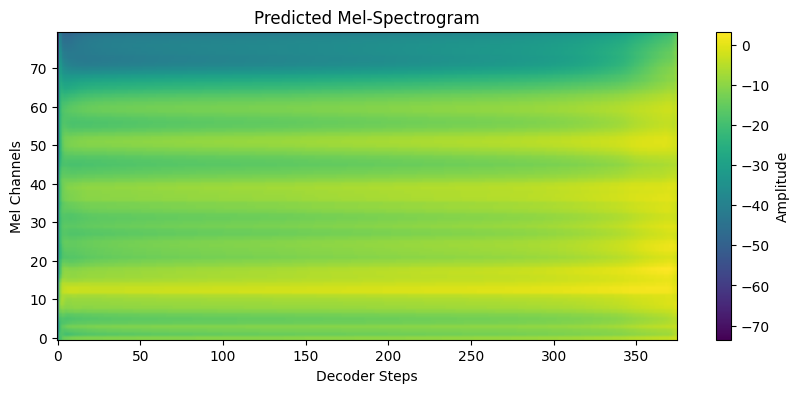

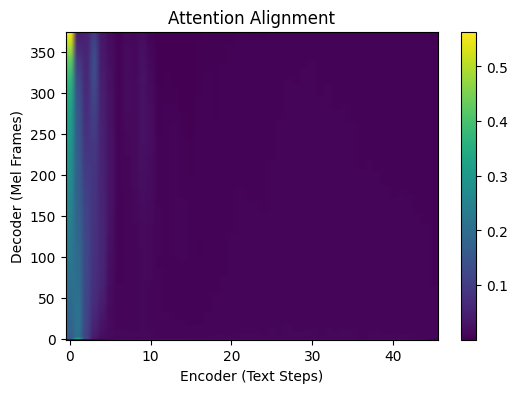

In [64]:
import numpy as np
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = "tacotron2_checkpoint_15.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

# speaker_ckpt = torch.load("/speaker_encoder_ge2e_epoch20.pth", map_location=device)
# speaker_encoder.load_state_dict(speaker_ckpt["model_state_dict"])
# speaker_encoder.to(device)
# speaker_encoder.eval()

mels_padded = np.load("savedpaths/mels_padded.npy")  # shape: [N, T, 80]
ref_mel = torch.from_numpy(mels_padded[0]).unsqueeze(0).to(device)  # [1, T, 80]

with torch.no_grad():
    speaker_emb = speaker_encoder(ref_mel)
    speaker_emb = speaker_emb / torch.norm(speaker_emb, dim=1, keepdim=True) 

text_input = "Hello world, this is Tacotron two with GE2E speaker embeddings."
text_input_cleaned = cleantext(text_input.lower())
phonemes = g2p_phonemes(text_input_cleaned)
text_seq = tokenizetext(phonemes)

text_tensor = torch.LongTensor(text_seq).unsqueeze(0).to(device)
text_len = torch.LongTensor([len(text_seq)]).to(device)

n_mels = 80
sr = 22050
hop_length = 256
max_decoder_steps = 1000
gate_threshold = 0.01

with torch.no_grad():
    mel_pred, mel_postnet, gate_out, alignments = model(
        text_tensor,
        text_len,
        teacher_forcing=False,
        speaker_embedding=speaker_emb,
    )

mel_output = mel_postnet.squeeze(0).cpu().numpy()
alignment = alignments.squeeze(0).cpu().numpy()

# 🔹 Visualize Mels
plt.figure(figsize=(10, 4))
plt.title("Predicted Mel-Spectrogram")
plt.imshow(mel_output.T, aspect="auto", origin="lower")
plt.colorbar(label="Amplitude")
plt.xlabel("Decoder Steps")
plt.ylabel("Mel Channels")
plt.show()

plt.figure(figsize=(6, 4))
plt.title("Attention Alignment")
plt.imshow(alignment, aspect="auto", origin="lower")
plt.xlabel("Encoder (Text Steps)")
plt.ylabel("Decoder (Mel Frames)")
plt.colorbar()
plt.show()


#  Corrected mel → audio
def mel_to_audio(mel, n_iter=60):
    """Converts log-mel spectrogram (Tacotron2 output) to waveform using Griffin-Lim"""
    n_fft = 1024
    hop_length = 256
    win_length = 1024
    n_mels = 80
    fmin = 125
    fmax = 7600

    # If Tacotron2 output is log-mel, convert back to linear mel power
    mel_power = librosa.db_to_power(mel.T)  

    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)
    inv_mel = np.maximum(1e-10, np.linalg.pinv(mel_basis) @ mel.T)
    audio = librosa.griffinlim(inv_mel, n_iter=n_iter, hop_length=hop_length, win_length=win_length)
    return audio


audio = mel_to_audio(mel_output)
sf.write("synthesized_audio.wav", audio, sr)

import IPython.display as ipd
ipd.Audio(audio, rate=sr)
